# Setting up the Simple `T`

In [46]:
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
session = Session(None)  # Used to run the TensorFlow graph

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
#Create 2 batch sim, target and source blob
#buoyancy is set to zero

world = World()
fluid = world.add(Fluid(Domain([48, 32], boundaries=CLOSED), buoyancy_factor=0.0), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=[5,16], radius=3), rate=5));
fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
states = []
states.append(fluid.state)  # Remember the state at t=0 for later visualization
session.initialize_variables()



In [48]:
#See tensorflow variables
[print(grid.data) for grid in fluid.velocity.unstack()];

<tf.Variable 'Variable/data/0/data_2:0' shape=(1, 49, 32, 1) dtype=float32_ref>
<tf.Variable 'Variable/data/1/data_2:0' shape=(1, 48, 33, 1) dtype=float32_ref>


Building graph for frame 0
Building graph for frame 1
Building graph for frame 2
Building graph for frame 3
Building graph for frame 4
Building graph for frame 5
Building graph for frame 6
Building graph for frame 7
Building graph for frame 8
Building graph for frame 9
Building graph for frame 10
Building graph for frame 11
Building graph for frame 12
Building graph for frame 13
Building graph for frame 14
Building graph for frame 15
Building graph for frame 16
Building graph for frame 17
Building graph for frame 18
Building graph for frame 19
Computing frames...


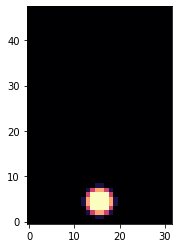

In [49]:
for frame in range(20):
  print('Building graph for frame %d' % frame)
  world.step(dt=0.5)
  states.append(fluid.state)


print('Computing frames...')
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [50]:
#Define loss function
#Want the densities of the right blob to match the ones of the left blob (target)
arr = np.load("t_only/sim_000001/density_000099.npz")

target = arr['arr_0']
loss = math.l2_loss(fluid.density.data[0:,...] - target)
optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
#optim = tf.train.AdadeltaOptimizer(learning_rate=5).minimize(loss)
session.initialize_variables()
print('Initial loss: %f' % session.run(loss))

Initial loss: 48861.687500


In [51]:
#Run optimization

for optim_step in range(300):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 48861.687500
Running optimization step 1. 
Loss: 43545.773438
Running optimization step 2. 
Loss: 40673.375000
Running optimization step 3. 
Loss: 38670.320312
Running optimization step 4. 
Loss: 37222.968750
Running optimization step 5. 
Loss: 36160.863281
Running optimization step 6. 
Loss: 35361.457031
Running optimization step 7. 
Loss: 34747.750000
Running optimization step 8. 
Loss: 34262.179688
Running optimization step 9. 
Loss: 33855.929688
Running optimization step 10. 
Loss: 33498.539062
Running optimization step 11. 
Loss: 33183.757812
Running optimization step 12. 
Loss: 32898.324219
Running optimization step 13. 
Loss: 32617.958984
Running optimization step 14. 
Loss: 32319.312500
Running optimization step 15. 
Loss: 31975.269531
Running optimization step 16. 
Loss: 31567.582031
Running optimization step 17. 
Loss: 31075.853516
Running optimization step 18. 
Loss: 30471.080078
Running optimizatio

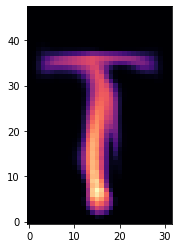

In [52]:
#See what this thing did

pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

In [53]:
#Checkout the optimized velocity field

optimized_velocity_field = session.run(states[0].velocity).at_centers()

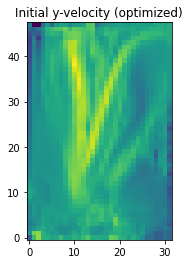

In [54]:
pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

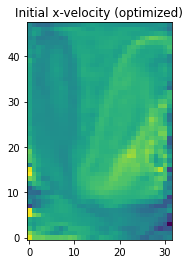

In [55]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

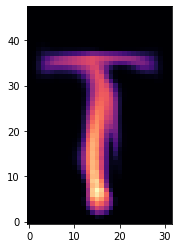

In [56]:

for i in range(len(states)):
    save_name = "t_vis/t_frame%d.png"
    pylab.imshow(np.concatenate(session.run(states[i].density).data[...,0], axis=1), origin='lower', cmap='magma')
    pylab.savefig(save_name % (i), bbox_inches='tight')
